### Train a wave detector using a simplified U-net architecture

https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py



In [ ]:
from surfbreak.base_models import WaveUnet
from torchsummary import summary

The plan is to input a 2-channel image with:
1. the fist channel the greyscale video intensity
2. second channel the delta intensity between this and the next timestep

In [ ]:
model = WaveUnet(n_class=1, n_input_channels=2)
model = model.to('cuda')
# Requires input x,y dimensions be evenly divisible by 4
summary(model, input_size=(2, 128, 256))  # NOTE: This might need batch-norm to work properly?  investigate later.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,216
              ReLU-2         [-1, 64, 128, 256]               0
         MaxPool2d-3          [-1, 64, 64, 128]               0
            Conv2d-4         [-1, 128, 64, 128]          73,856
              ReLU-5         [-1, 128, 64, 128]               0
         MaxPool2d-6          [-1, 128, 32, 64]               0
            Conv2d-7          [-1, 256, 32, 64]         295,168
              ReLU-8          [-1, 256, 32, 64]               0
          Upsample-9         [-1, 256, 64, 128]               0
           Conv2d-10         [-1, 128, 64, 128]         442,496
             ReLU-11         [-1, 128, 64, 128]               0
         Upsample-12        [-1, 128, 128, 256]               0
           Conv2d-13         [-1, 64, 128, 256]         110,656
             ReLU-14         [-1, 64, 1

In [ ]:
from surfbreak.datasets import WaveformVideoDataset, cache_video_dataset_as_inferred_xy_images
import torch
from surfbreak.waveform_models import LitSirenNet
from surfbreak.supervision import animate_tensor

def animate_model(model, xrange=(200,300), video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'):
    wf_valid_video_dataset = WaveformVideoDataset(video_filepath, ydim=120, xrange=xrange, timerange=model.hparams['timerange'], time_chunk_duration_s=30, 
                                                  time_chunk_stride_s=30, time_axis_scale=0.5)
    model_input, ground_truth = wf_valid_video_dataset[2]
    model = model.cpu().train(False)
    wf_values_out, coords_out = model(model_input['coords_txyc'])
    wf_out_txy = wf_values_out[...,0].detach()
    # Dividing video image values by 4 to scale to fit output range
    vid_waveform_sidebyside_txy = torch.cat((ground_truth['video_txy']/4, wf_out_txy), dim=1)
    return animate_tensor(vid_waveform_sidebyside_txy.numpy().transpose(2,1,0), colorbar=True)

In [ ]:
model = LitSirenNet.load_from_checkpoint('../bestlogs/optimized_waveform_x400_t90/checkpoints/epoch=20.ckpt', video_filepath='../data/shirahama_1590387334_SURF-93cm.ts')
#animate_model(model, video_filepath='../data/shirahama_1590387334_SURF-93cm.ts')

Define the training dataset and lightning model class

In [ ]:
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
tmpdir='./tmp/dataset_cache'
wf_valid_video_dataset = WaveformVideoDataset(video_filepath, ydim=120, xrange=(0,200), timerange=(0,30), time_chunk_duration_s=30, 
                                                  time_chunk_stride_s=30, time_axis_scale=0.5)
fname_pairs = cache_video_dataset_as_inferred_xy_images(wf_valid_video_dataset, model, tmpdir=tmpdir)
fname_pairs[:5]

[('c0_t0_video_xy', 'c0_t0_waveform_xyc'),
 ('c0_t1_video_xy', 'c0_t1_waveform_xyc'),
 ('c0_t2_video_xy', 'c0_t2_waveform_xyc'),
 ('c0_t3_video_xy', 'c0_t3_waveform_xyc'),
 ('c0_t4_video_xy', 'c0_t4_waveform_xyc')]

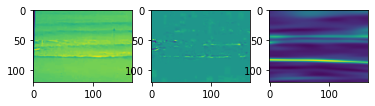

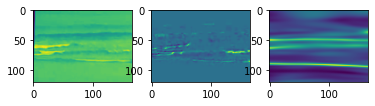

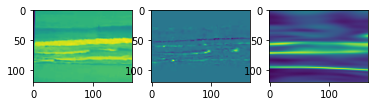

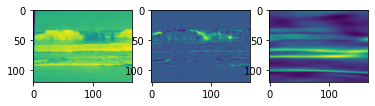

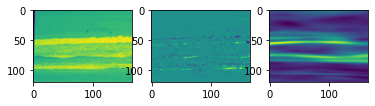

In [ ]:
import matplotlib.pyplot as plt
import os
import pickle
for vid, wf in fname_pairs[:100:20]:
    with open(os.path.join(tmpdir, vid), 'rb') as f:
        vid_xy = pickle.load(f)
    with open(os.path.join(tmpdir, wf), 'rb') as f:
        wf_xy = pickle.load(f)
    fig, axes = plt.subplots(ncols=3, figsize=(6,3))
    axes[0].imshow(vid_xy[0].T)
    axes[1].imshow(vid_xy[1].T)
    axes[2].imshow(wf_xy.T)

### Actually try training it!

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN

pl.seed_everything(42)

tb_logger = pl.loggers.TensorBoardLogger('../logs/', name="wavecnn")
trainer = pl.Trainer(logger=tb_logger, limit_val_batches=3,
                     max_epochs=20, 
                     gpus=1 if torch.cuda.is_available() else None,)

                             # Params from optimization run: fo 2.4967  ho 10.969  ss 0.20492  wfls 5.4719e-9  wsls 0.00043457
wavecnn_model = LitWaveCNN(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts', 
                             wf_model_checkpoint='../bestlogs/optimized_waveform_x400_t90/checkpoints/epoch=20.ckpt', 
                             learning_rate=1e-4, xrange=(0,400), timerange=(0,90), chunk_duration=30, chunk_stride=30,
                             n_input_channels=2)
    
trainer.fit(wavecnn_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | In sizes         | Out sizes       
-------------------------------------------------------------------------
0 | model | WaveUnet | 923 K  | [1, 2, 256, 256] | [1, 1, 256, 256]


1

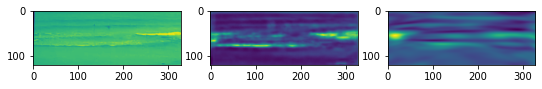

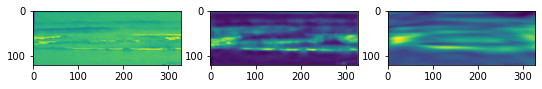

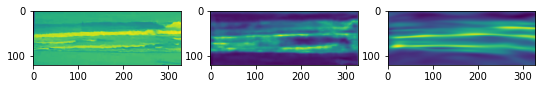

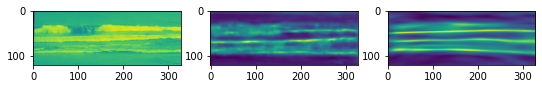

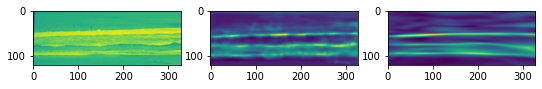

In [ ]:
from surfbreak.datasets import trim_img_to_nearest_multiple

video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
tmpdir='./tmp/dataset_cache'
wf_valid_video_dataset = WaveformVideoDataset(video_filepath, ydim=120, xrange=(0,200), timerange=(0,30), time_chunk_duration_s=30, 
                                                  time_chunk_stride_s=30, time_axis_scale=0.5)

fname_pairs = wavecnn_model.inferred_waveform_dataset.fname_pairs

import matplotlib.pyplot as plt
for vid, wf in fname_pairs[:100:20]:
    with open(os.path.join(tmpdir, vid), 'rb') as f:
        vid_xy = pickle.load(f)
    with open(os.path.join(tmpdir, wf), 'rb') as f:
        wf_xy = pickle.load(f)
    fig, axes = plt.subplots(ncols=3, figsize=(9,3))
    trimmed_vid_img = trim_img_to_nearest_multiple(vid_xy)
    trimmed_wf_img = trim_img_to_nearest_multiple(wf_xy)
    # Pad 2 empty dimensions to give it the right shape...
    inferred_wavefronts = wavecnn_model(torch.from_numpy(trimmed_vid_img)[None,...].cuda()) 
    axes[0].imshow(trimmed_vid_img[0].T)
    axes[1].imshow(inferred_wavefronts[0,0].detach().cpu().T)
    axes[2].imshow(trimmed_wf_img.T)
    

## Now configure it to load from a checkpoint
And then it can be used!

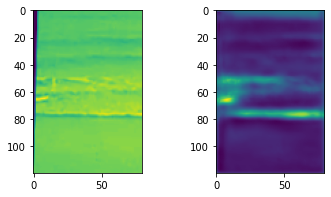

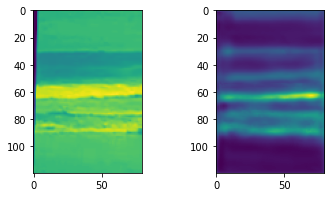

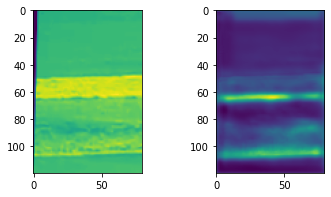

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN
from surfbreak.datasets import WaveformVideoDataset, InferredWaveformDataset,\
                               trim_img_to_nearest_multiple, video_txy_to_wavecnn_array_cxy

video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
tmpdir='./tmp/dataset_cache'


wf_valid_video_dataset = WaveformVideoDataset(video_filepath, ydim=120, xrange=(0,100), timerange=(0,60), time_chunk_duration_s=30, 
                                                  time_chunk_stride_s=30, time_axis_scale=0.5)

wavecnn_model = LitWaveCNN.load_from_checkpoint('../bestlogs/wavecnn/checkpoints/epoch=19.ckpt', 
                                                 wf_model_checkpoint='../bestlogs/optimized_waveform_x400_t90/checkpoints/epoch=20.ckpt',)

model_input, gt = wf_valid_video_dataset[0]

def detect_wavefronts_at_t(video_txy, t, wavecnn_model):
    input_img_array_cxy = video_txy_to_wavecnn_array_cxy(video_txy, t)
    cnnmodel_input = trim_img_to_nearest_multiple(input_img_array_cxy[None,...]) 
    waveform_img = wavecnn_model(cnnmodel_input)
    return waveform_img[0,0].detach().numpy()

import matplotlib.pyplot as plt
for t_idx in range(0,gt['video_txy'].shape[0]-1,50):
    wavecnn_img = detect_wavefronts_at_t(gt['video_txy'], t_idx, wavecnn_model)
    fig, axes = plt.subplots(ncols=2, figsize=(6,3))
    axes[0].imshow(trim_img_to_nearest_multiple(gt['video_txy'][t_idx]).T)
    axes[1].imshow(wavecnn_img.T)

